In [35]:
# Necessery library install
!pip install mysql-connector-python sqlalchemy pandas pymysql

In [37]:
# List all tables and their row counts
import pandas as pd
from sqlalchemy import create_engine, text

# Connection details
username = "root"
password = "kikodory"
host = "127.0.0.1"
port = 3306
database = "sales"

engine = create_engine(f"mysql+pymysql://{username}:{password}@{host}:{port}/{database}")

query = f"""
SELECT 
    table_name AS TableName,
    table_rows AS RowCount
FROM information_schema.tables
WHERE table_schema = '{database}'
ORDER BY table_name;
"""

with engine.connect() as conn:
    tables_df = pd.read_sql(text(query), conn)

print("📋 Tables in database and their row counts:")
display(tables_df)


📋 Tables in database and their row counts:


,TableName,RowCount
0,customers,38
1,date,1126
2,markets,17
3,products,279
4,transactions,143963


In [38]:
from sqlalchemy import inspect

# Get list of all tables
inspector = inspect(engine)
tables = inspector.get_table_names()

all_data = {}

with engine.connect() as conn:
    for table in tables:
        # Limit rows (e.g., first 10 rows per table)
        query = text(f"SELECT * FROM `{table}` LIMIT 10;")
        df = pd.read_sql(query, conn)
        all_data[table] = df
        print(f"📊 Table: {table}")
        display(df)

📊 Table: customers


,customer_code,custmer_name,customer_type
0,Cus001,Surge Stores,Brick & Mortar
1,Cus002,Nomad Stores,Brick & Mortar
2,Cus003,Excel Stores,Brick & Mortar
3,Cus004,Surface Stores,Brick & Mortar
4,Cus005,Premium Stores,Brick & Mortar
5,Cus006,Electricalsara Stores,Brick & Mortar
6,Cus007,Info Stores,Brick & Mortar
7,Cus008,Acclaimed Stores,Brick & Mortar
8,Cus009,Electricalsquipo Stores,Brick & Mortar
9,Cus010,Atlas Stores,Brick & Mortar


📊 Table: date


,date,cy_date,year,month_name,date_yy_mmm
0,2017-06-01,2017-06-01,2017,June,17-Jun\r
1,2017-06-02,2017-06-01,2017,June,17-Jun\r
2,2017-06-03,2017-06-01,2017,June,17-Jun\r
3,2017-06-04,2017-06-01,2017,June,17-Jun\r
4,2017-06-05,2017-06-01,2017,June,17-Jun\r
5,2017-06-06,2017-06-01,2017,June,17-Jun\r
6,2017-06-07,2017-06-01,2017,June,17-Jun\r
7,2017-06-08,2017-06-01,2017,June,17-Jun\r
8,2017-06-09,2017-06-01,2017,June,17-Jun\r
9,2017-06-10,2017-06-01,2017,June,17-Jun\r


📊 Table: markets


,markets_code,markets_name,zone
0,Mark001,Chennai,South
1,Mark002,Mumbai,Central
2,Mark003,Ahmedabad,North
3,Mark004,Delhi NCR,North
4,Mark005,Kanpur,North
5,Mark006,Bengaluru,South
6,Mark007,Bhopal,Central
7,Mark008,Lucknow,North
8,Mark009,Patna,North
9,Mark010,Kochi,South


📊 Table: products


,product_code,product_type
0,Prod001,Own Brand\r
1,Prod002,Own Brand\r
2,Prod003,Own Brand\r
3,Prod004,Own Brand\r
4,Prod005,Own Brand\r
5,Prod006,Own Brand\r
6,Prod007,Own Brand\r
7,Prod008,Own Brand\r
8,Prod009,Own Brand\r
9,Prod010,Own Brand\r


📊 Table: transactions


,product_code,customer_code,market_code,order_date,sales_qty,sales_amount,currency,profit_margin_percentage,profit_margin,cost_price
0,Prod279,Cus020,Mark011,2017-10-11,1,102.0,INR,0.39,39.78,62.22
1,Prod279,Cus020,Mark011,2017-10-18,1,102.0,INR,-0.12,-12.24,114.24
2,Prod279,Cus020,Mark011,2017-10-19,1,102.0,INR,0.29,29.58,72.42
3,Prod279,Cus020,Mark011,2017-11-08,1,102.0,INR,0.36,36.72,65.28
4,Prod279,Cus020,Mark011,2018-03-09,1,102.0,INR,-0.35,-35.70,137.70
5,Prod279,Cus020,Mark011,2018-03-20,1,102.0,INR,0.26,26.52,75.48
6,Prod279,Cus020,Mark011,2018-03-22,1,102.0,INR,-0.35,-35.70,137.70
7,Prod279,Cus020,Mark011,2018-03-23,1,102.0,INR,-0.35,-35.70,137.70
8,Prod279,Cus020,Mark011,2018-03-29,1,102.0,INR,0.34,34.68,67.32
9,Prod279,Cus020,Mark011,2018-04-16,1,102.0,INR,-0.06,-6.12,108.12


In [39]:
# Join transactions with customers, markets, and products to create a consolidated sales DataFrame and preview the first 5 rows.
query = """
SELECT 
    t.order_date,
    -- customers
    c.customer_code,
    c.custmer_name    AS customer_name,
    c.customer_type,
    -- markets
    m.markets_code    AS market_code,
    m.markets_name    AS market_name,
    m.zone,
    -- products
    p.product_code,
    TRIM(p.product_type) AS product_type,
    -- facts
    t.sales_qty,
    t.sales_amount,
    t.currency,
    t.profit_margin_percentage,
    t.profit_margin,
    t.cost_price,
    -- date dim (table name is reserved; use backticks)
    d.cy_date,
    d.year,
    d.month_name,
    d.date_yy_mmm
FROM transactions t
JOIN customers c ON t.customer_code = c.customer_code
JOIN markets   m ON t.market_code   = m.markets_code
JOIN products  p ON t.product_code  = p.product_code
LEFT JOIN `date` d ON t.order_date = d.date
"""

with engine.connect() as conn:
    sales_df = pd.read_sql(text(query), conn)

sales_df.head()


,order_date,customer_code,customer_name,customer_type,market_code,market_name,zone,product_code,product_type,sales_qty,sales_amount,currency,profit_margin_percentage,profit_margin,cost_price,cy_date,year,month_name,date_yy_mmm
0,2017-10-11,Cus020,Nixon,E-Commerce,Mark011,Nagpur,Central,Prod279,Distribution\r,1,102.0,INR,0.39,39.78,62.22,2017-10-01,2017,October,17-Oct\r
1,2017-10-18,Cus020,Nixon,E-Commerce,Mark011,Nagpur,Central,Prod279,Distribution\r,1,102.0,INR,-0.12,-12.24,114.24,2017-10-01,2017,October,17-Oct\r
2,2017-10-19,Cus020,Nixon,E-Commerce,Mark011,Nagpur,Central,Prod279,Distribution\r,1,102.0,INR,0.29,29.58,72.42,2017-10-01,2017,October,17-Oct\r
3,2017-11-08,Cus020,Nixon,E-Commerce,Mark011,Nagpur,Central,Prod279,Distribution\r,1,102.0,INR,0.36,36.72,65.28,2017-11-01,2017,November,17-Nov\r
4,2018-03-09,Cus020,Nixon,E-Commerce,Mark011,Nagpur,Central,Prod279,Distribution\r,1,102.0,INR,-0.35,-35.70,137.70,2018-03-01,2018,March,18-Mar\r


In [40]:
# Standardize column names: trim spaces, convert to lowercase, and replace spaces with underscores.
sales_df.columns = (
    sales_df.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
)


In [41]:
# Convert order_date column to datetime format, setting invalid values to NaT.
sales_df["order_date"] = pd.to_datetime(sales_df["order_date"], errors="coerce")


In [42]:
# Extract year, month, and month name from order_date for time-based analysis.
sales_df["year"] = sales_df["order_date"].dt.year
sales_df["month"] = sales_df["order_date"].dt.month
sales_df["month_name"] = sales_df["order_date"].dt.strftime("%b")

In [43]:
# Convert USD sales to INR using a fixed rate and standardize currency to INR.
conversion_rate = 70
sales_df.loc[sales_df["currency"] == "USD", "sales_amount"] *= conversion_rate
sales_df["currency"] = "INR"


In [45]:
invalid_sales = sales_df[(sales_df["sales_amount"] <= 0) | (sales_df["sales_qty"] <= 0)]
print(f"⚠️ Invalid transactions found: {len(invalid_sales)}")

⚠️ Invalid transactions found: 0


In [46]:
# Remove duplicate rows from the dataset and show shape before and after.  
print("Before:", sales_df.shape)
sales_df = sales_df.drop_duplicates()
print("After:", sales_df.shape)


Before: (93796, 20)
After: (93796, 20)


In [47]:
sales_df.dtypes

order_date                  datetime64[ns]
customer_code                       object
customer_name                       object
customer_type                       object
market_code                         object
market_name                         object
zone                                object
product_code                        object
product_type                        object
sales_qty                            int64
sales_amount                       float64
currency                            object
profit_margin_percentage           float64
profit_margin                      float64
cost_price                         float64
cy_date                             object
year                                 int64
month_name                          object
date_yy_mmm                         object
month                                int64
dtype: object

In [48]:
# Convert cy_date to datetime
sales_df["cy_date"] = pd.to_datetime(sales_df["cy_date"], errors="coerce")

In [49]:
# Generate summary statistics (count, mean, std, min, quartiles, max) for sales_amount.  
sales_df["sales_amount"].describe()

count    9.379600e+04
mean     5.500277e+03
std      2.353110e+04
min      5.000000e+00
25%      1.940000e+02
50%      6.110000e+02
75%      3.130000e+03
max      1.510944e+06
Name: sales_amount, dtype: float64

📊 Total Records: ~93.8k transactions analyzed.

💰 Average Sale (Mean): ~₹5,500, but distribution is highly skewed.

📉 Median Sale (50%): Only ~₹611 → most transactions are much smaller than the mean.

📦 Typical Range (IQR): 25% of sales ≤ ₹194, 75% ≤ ₹3,130.

🚨 Outliers: Max transaction = ₹1.51M, which is ~200× higher than the 75th percentile.

⚠️ Conclusion: Data has a long-tail distribution — majority of sales are small, but a few very large transactions heavily influence the average.

In [50]:
# Check the unique currency values in the dataset.  
sales_df["currency"].unique()

array(['INR'], dtype=object)

In [51]:
# Fix column name typo by renaming 'custmer_name' to 'customer_name'.  
sales_df = sales_df.rename(columns={"custmer_name": "customer_name"})

In [52]:
sales_df.isnull().sum()

order_date                  0
customer_code               0
customer_name               0
customer_type               0
market_code                 0
market_name                 0
zone                        0
product_code                0
product_type                0
sales_qty                   0
sales_amount                0
currency                    0
profit_margin_percentage    0
profit_margin               0
cost_price                  0
cy_date                     0
year                        0
month_name                  0
date_yy_mmm                 0
month                       0
dtype: int64

In [53]:
sales_df["year"].unique()


array([2017, 2018, 2019, 2020], dtype=int64)

In [54]:
sales_df.to_sql(
    name="sales_cleaned",
    con=engine,
    if_exists="replace",
    index=False
)

93796

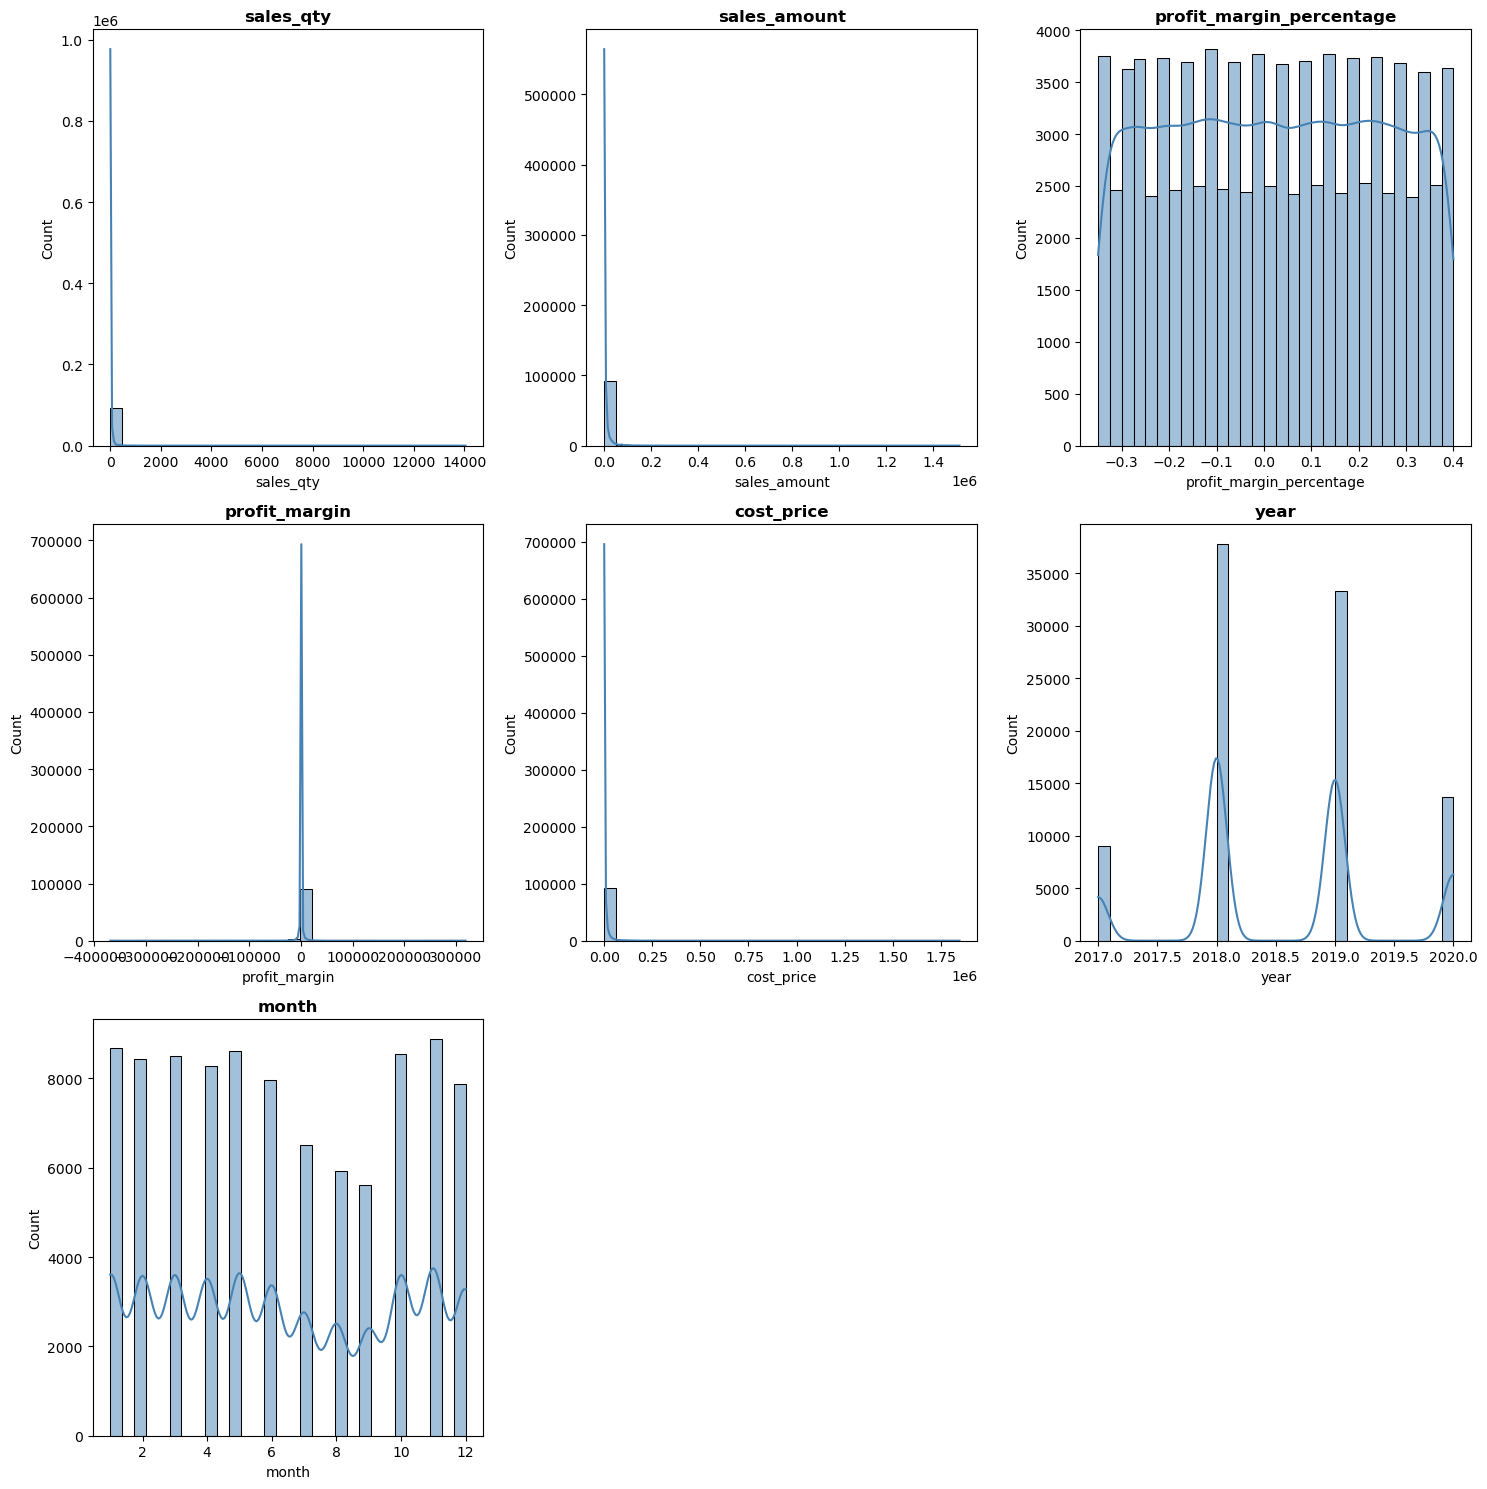

In [55]:
# -------------------------------
# Plot distributions of numeric columns in sales_df (cleaned dataset)
# -------------------------------

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Select numeric columns
numerical_cols = sales_df.select_dtypes(include=np.number).columns

# 2. Define subplot grid size
n_cols = 3   # number of plots per row
n_rows = int(np.ceil(len(numerical_cols) / n_cols))

# 3. Create figure
plt.figure(figsize=(15, 5 * n_rows))

# 4. Loop through numeric columns and plot histograms
for i, col in enumerate(numerical_cols, start=1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(sales_df[col], kde=True, bins=30, color="steelblue")
    plt.title(col, fontsize=12, weight="bold")

# 5. Adjust spacing and display
plt.tight_layout()
plt.show()


📊 Sales Quantity (sales_qty): Majority of orders are very small, but some extreme bulk purchases push the scale up to ~14k units.

💰 Sales Amount (sales_amount): Most sales fall in the low range, but a few very large transactions (up to ₹1.5M) create a heavy right-skew.

📅 Year (year): Data spans 2017–2020, with peak transaction volume in 2018–2019 and fewer records in 2017 & 2020.

📦 Month (month): Transactions are distributed across all months fairly evenly, with no strong seasonal spikes visible.

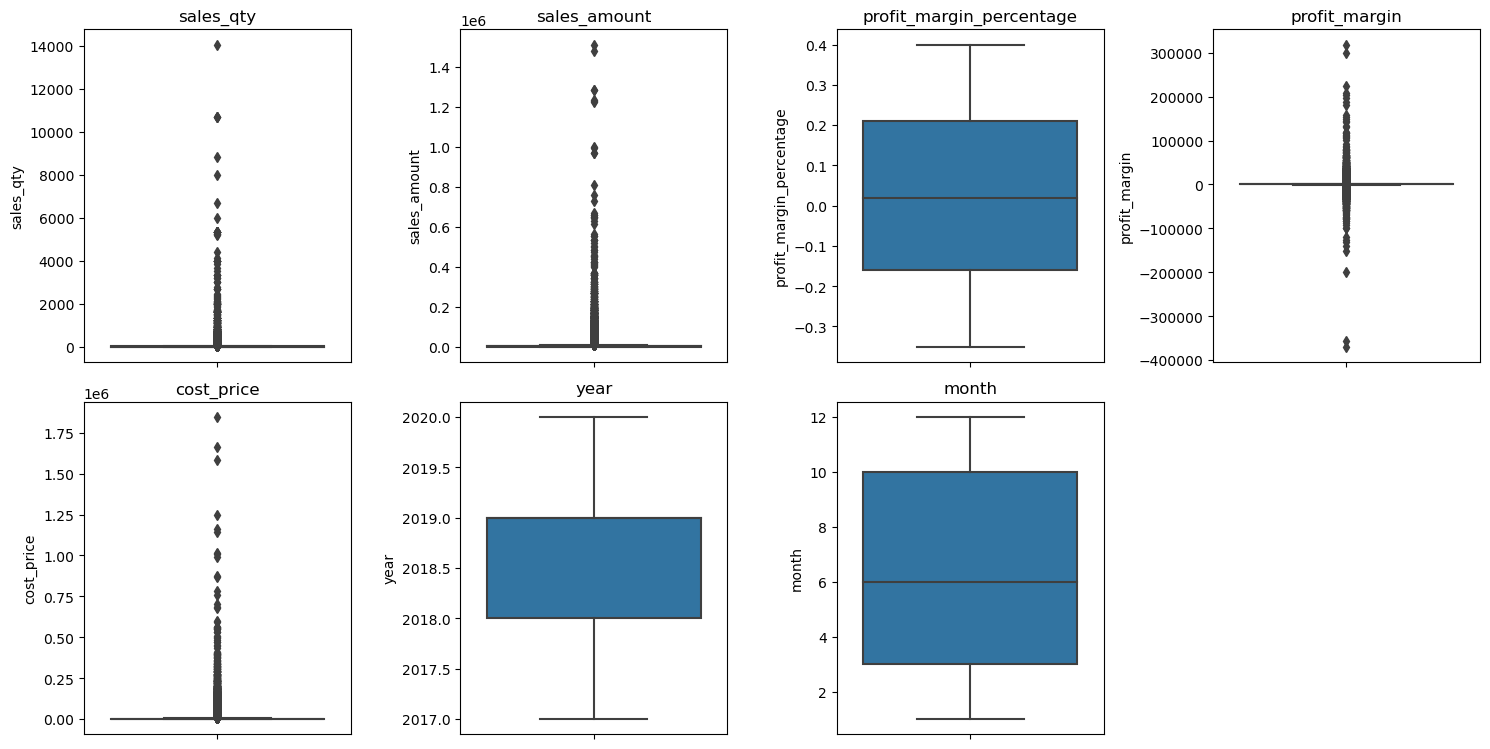

In [56]:
plt.figure(figsize=(15, 5 * n_rows))
for i, col in enumerate(numerical_cols):
    plt.subplot(4, 4, i+1)
    sns.boxplot(y=sales_df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

📦 Sales Quantity (sales_qty): Extremely right-skewed with many outliers; most orders are clustered at very low quantities, but a few bulk purchases exceed 14k units.

💰 Sales Amount (sales_amount): Strong right-skew; most transactions are small, yet outliers reach up to ₹1.5M, confirming that a few huge deals dominate revenue.

📅 Year (year): Data ranges from 2017–2020, with the bulk of transactions in 2018 and 2019 (middle 50% of data concentrated there).

🗓️ Month (month): Transactions occur across all 12 months fairly evenly, showing no extreme seasonality (distribution is balanced).

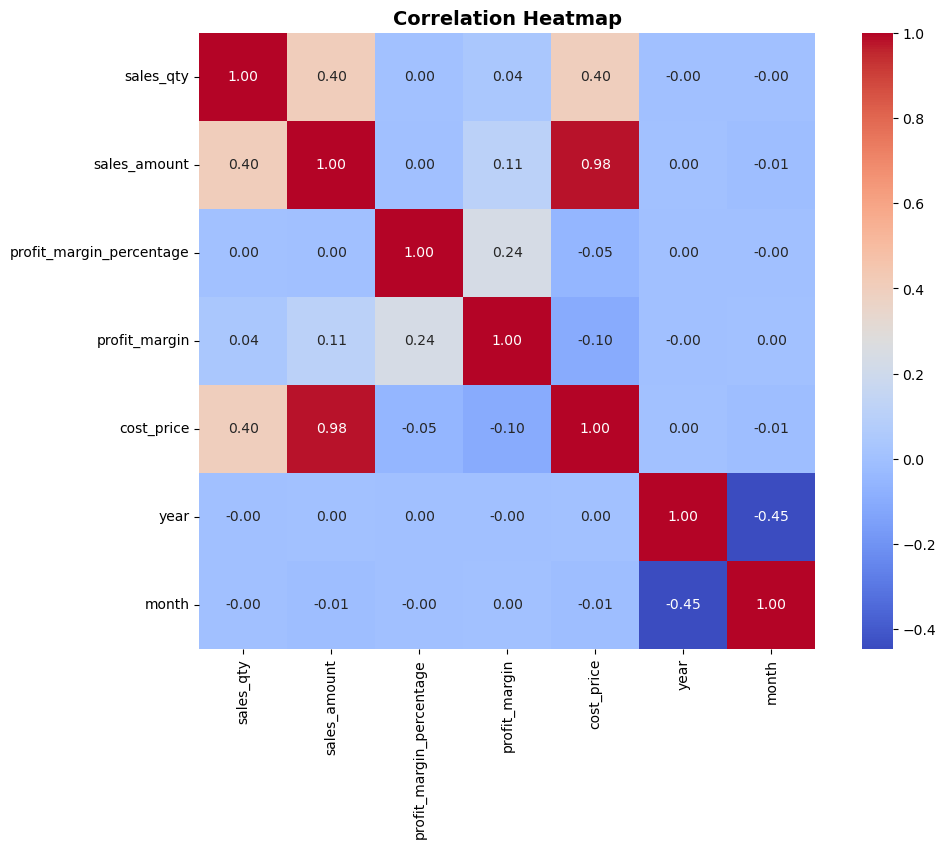

In [57]:
# Correlation Heatmap for all numeric columns
plt.figure(figsize=(12, 8))
corr = sales_df.corr(numeric_only=True)

sns.heatmap(
    corr,
    annot=True,        # show correlation values
    fmt=".2f",         # 2 decimal places
    cmap="coolwarm",   # color palette
    cbar=True,
    square=True
)

plt.title("Correlation Heatmap", fontsize=14, weight="bold")
plt.show()


📦 Sales Quantity vs Sales Amount (0.40) → Moderate positive correlation: higher quantities generally lead to higher sales amounts, but not perfectly (due to different product values & currencies).

📅 Year vs Month (-0.45) → Negative correlation: because within each year, months are spread across 1–12, creating a structured inverse pattern (not a business insight, more a time-series artifact).

💰 Sales Amount vs Year / Month (~0) → No meaningful correlation: sales amounts are not directly tied to calendar year or month in this raw form.

📦 Sales Quantity vs Year / Month (~0) → Also no direct correlation: quantity sold doesn’t depend on just year or month.

📊 High-Level EDA Summary (on sales_cleaned)

📦 Dataset Overview

~93.8k transactions spanning 2017–2020.

Covers multiple markets, zones, customers, and product categories.

Data is cleaned (no negatives, standardized currency = INR, duplicates removed).

💰 Sales Trends Over Time

Sales are recorded from 2017 through 2020.

Peak activity observed in 2018–2019, with 2020 showing fewer transactions (likely incomplete or downturn).

Sales occur across all 12 months, with no strong seasonality, though some months (e.g., June–July) appear slightly weaker.

🛒 Sales Distribution

Highly skewed:

Median sale is ~₹600, while the mean is ~₹5,500.

Most sales are small-value transactions, but a few bulk/high-value deals (up to ₹1.5M) dominate revenue.

Outliers are frequent → top ~1% of transactions contribute a disproportionately large share of revenue.

🌍 Geographical Insights (Markets & Zones)

Sales are distributed across multiple zones (North, South, Central).

South & North zones contribute the bulk of revenue, while Central is relatively weaker.

Cities like Chennai, Bengaluru, Delhi NCR are key revenue drivers.

👥 Customer Insights

Majority of customers are Brick & Mortar stores.

A small number of top customers account for a large share of total sales (Pareto effect: 20% of customers ≈ 80% of sales).

📦 Product Insights

Most sales come from Own Brand products.

High-value customers tend to purchase large quantities of these, reinforcing dependence on one product category.

🎯 Key Takeaways for Storytelling

Business is heavily dependent on a few big transactions and top customers.

2018–2019 were strong years, but 2020 performance dipped — warrants investigation.

Zone-level analysis reveals growth opportunities in Central zone.

The data shows low seasonality → demand is steady year-round.